In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, BackwardDifferenceEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error as mse
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.neighbors import KNeighborsRegressor


import warnings 
warnings.simplefilter('ignore')

In [3]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
print(f'Train :{train_df.shape[0]}')
print(f'Test :{test_df.shape[0]}')

Train :1460
Test :1459


In [6]:
train_ids = train_df['Id'].values
test_ids = test_df['Id'].values

In [7]:
concat_df = pd.concat((train_df, test_df))
concat_df.drop('SalePrice',axis=1, inplace=True)

concat_df.shape

(2919, 80)

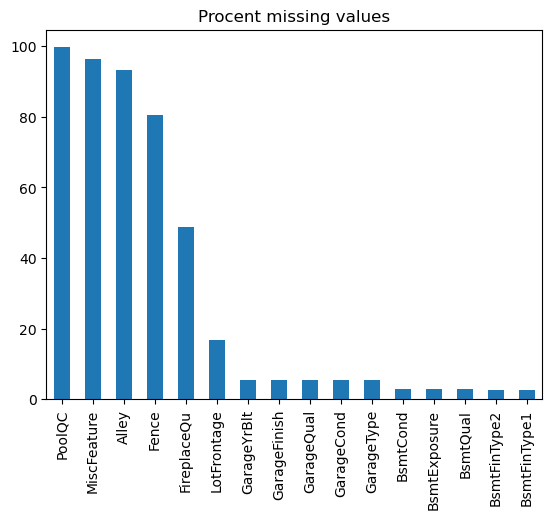

In [8]:
miss_proc = (concat_df.isna().sum() * 100) /concat_df.shape[0]
miss_proc = miss_proc[miss_proc > 1].sort_values(ascending=False)

miss_proc.plot.bar()
plt.title('Procent missing values')
plt.show()

In [9]:

miss_to_binary_cols = miss_proc[miss_proc > 40].index.tolist()

for col in miss_to_binary_cols:
    concat_df[col] = concat_df[col].isna().apply(lambda x: 0 if x else 1)
#concat_df.drop(miss_to_binary_cols, axis=1, inplace=True)

concat_df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [10]:
concat_df[miss_to_binary_cols]

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu
0,0,0,0,0,0
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
1454,0,0,0,0,0
1455,0,0,0,0,0
1456,0,0,0,0,1
1457,0,1,0,1,0


In [11]:
# по условю колонка категориальная
concat_df['MSSubClass'] = concat_df['MSSubClass'].astype('O')

categ_cols = [col for col in concat_df.columns if concat_df[col].dtype == 'O']
numeric_cols = [col for col in concat_df.columns if concat_df[col].dtype != 'O']

In [12]:
#заполним пропуски

def impute_miss(df_origin):
    df = df_origin.copy()
    for col in df.columns:
        if col in categ_cols:
            mode = df[col].mode()[0]
            df[col] = df[col].fillna('None')
            
        else: # колонка вещественная 
            median = df[col].median()
            df[col] = df[col].fillna(0) 
    #test
    num_miss = df.isna().sum().sum()
    if num_miss == 0:
        print('Impute success!')
        return df
    else:
        raise 'Impute Error :('
        

concat_df = impute_miss(concat_df)


Impute success!


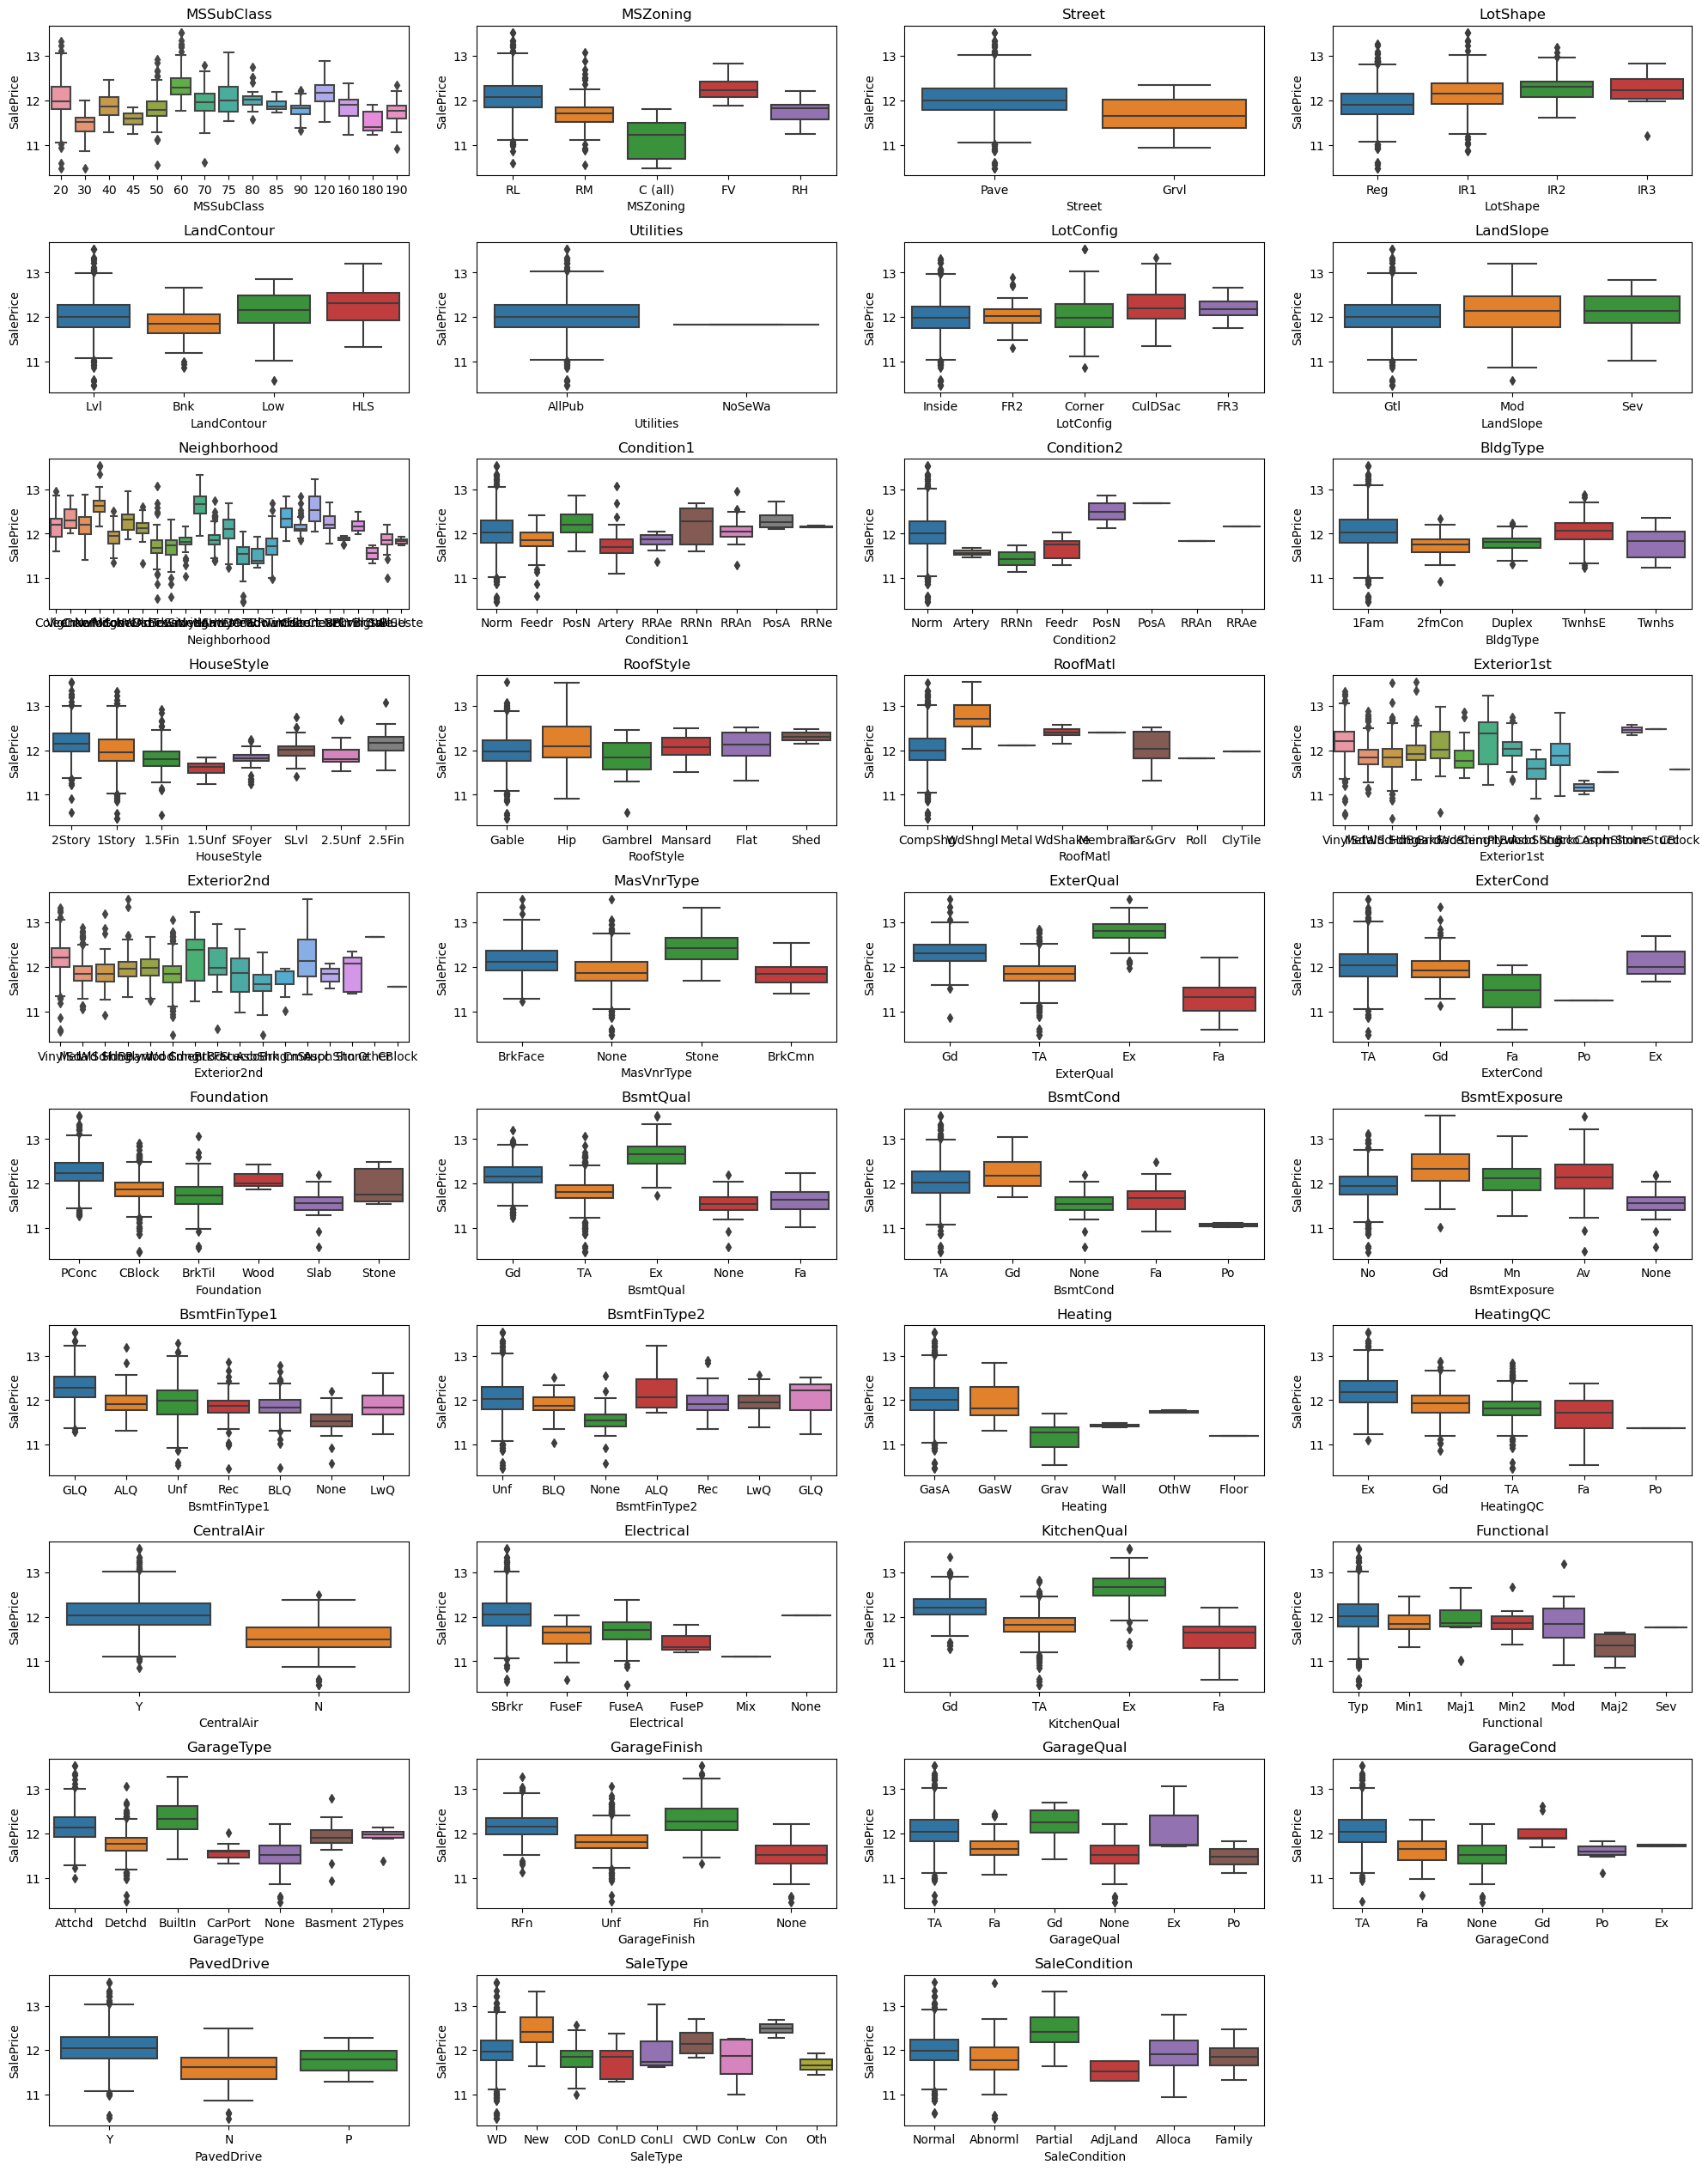

In [13]:
# посмотрим на природу взаимосвязи категориальных переменных и таргета
fig = plt.figure()
fig.set_size_inches(20,30)


df_for_vis = concat_df[:1460]
for i, col in enumerate(categ_cols):
    fig.add_subplot(12,4,i+1)
    plt.title(col)
    fig.tight_layout(h_pad=1)
    sns.boxplot(x=df_for_vis[col],y=np.log(train_df['SalePrice']))
    

## Выводы
* в некоторых признаках, на определенном классе распределение таргета сильно отличается 
* это происходит изза несбалансированности классов в таких колонках
* продемонстрируем на примере колонки SaleType, видно что распределение таргета в классе WD, сильно отличается

In [14]:
concat_df['SaleType'].value_counts()

WD       2525
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
None        1
Name: SaleType, dtype: int64

* как видим все дело в дисбалансе классов 

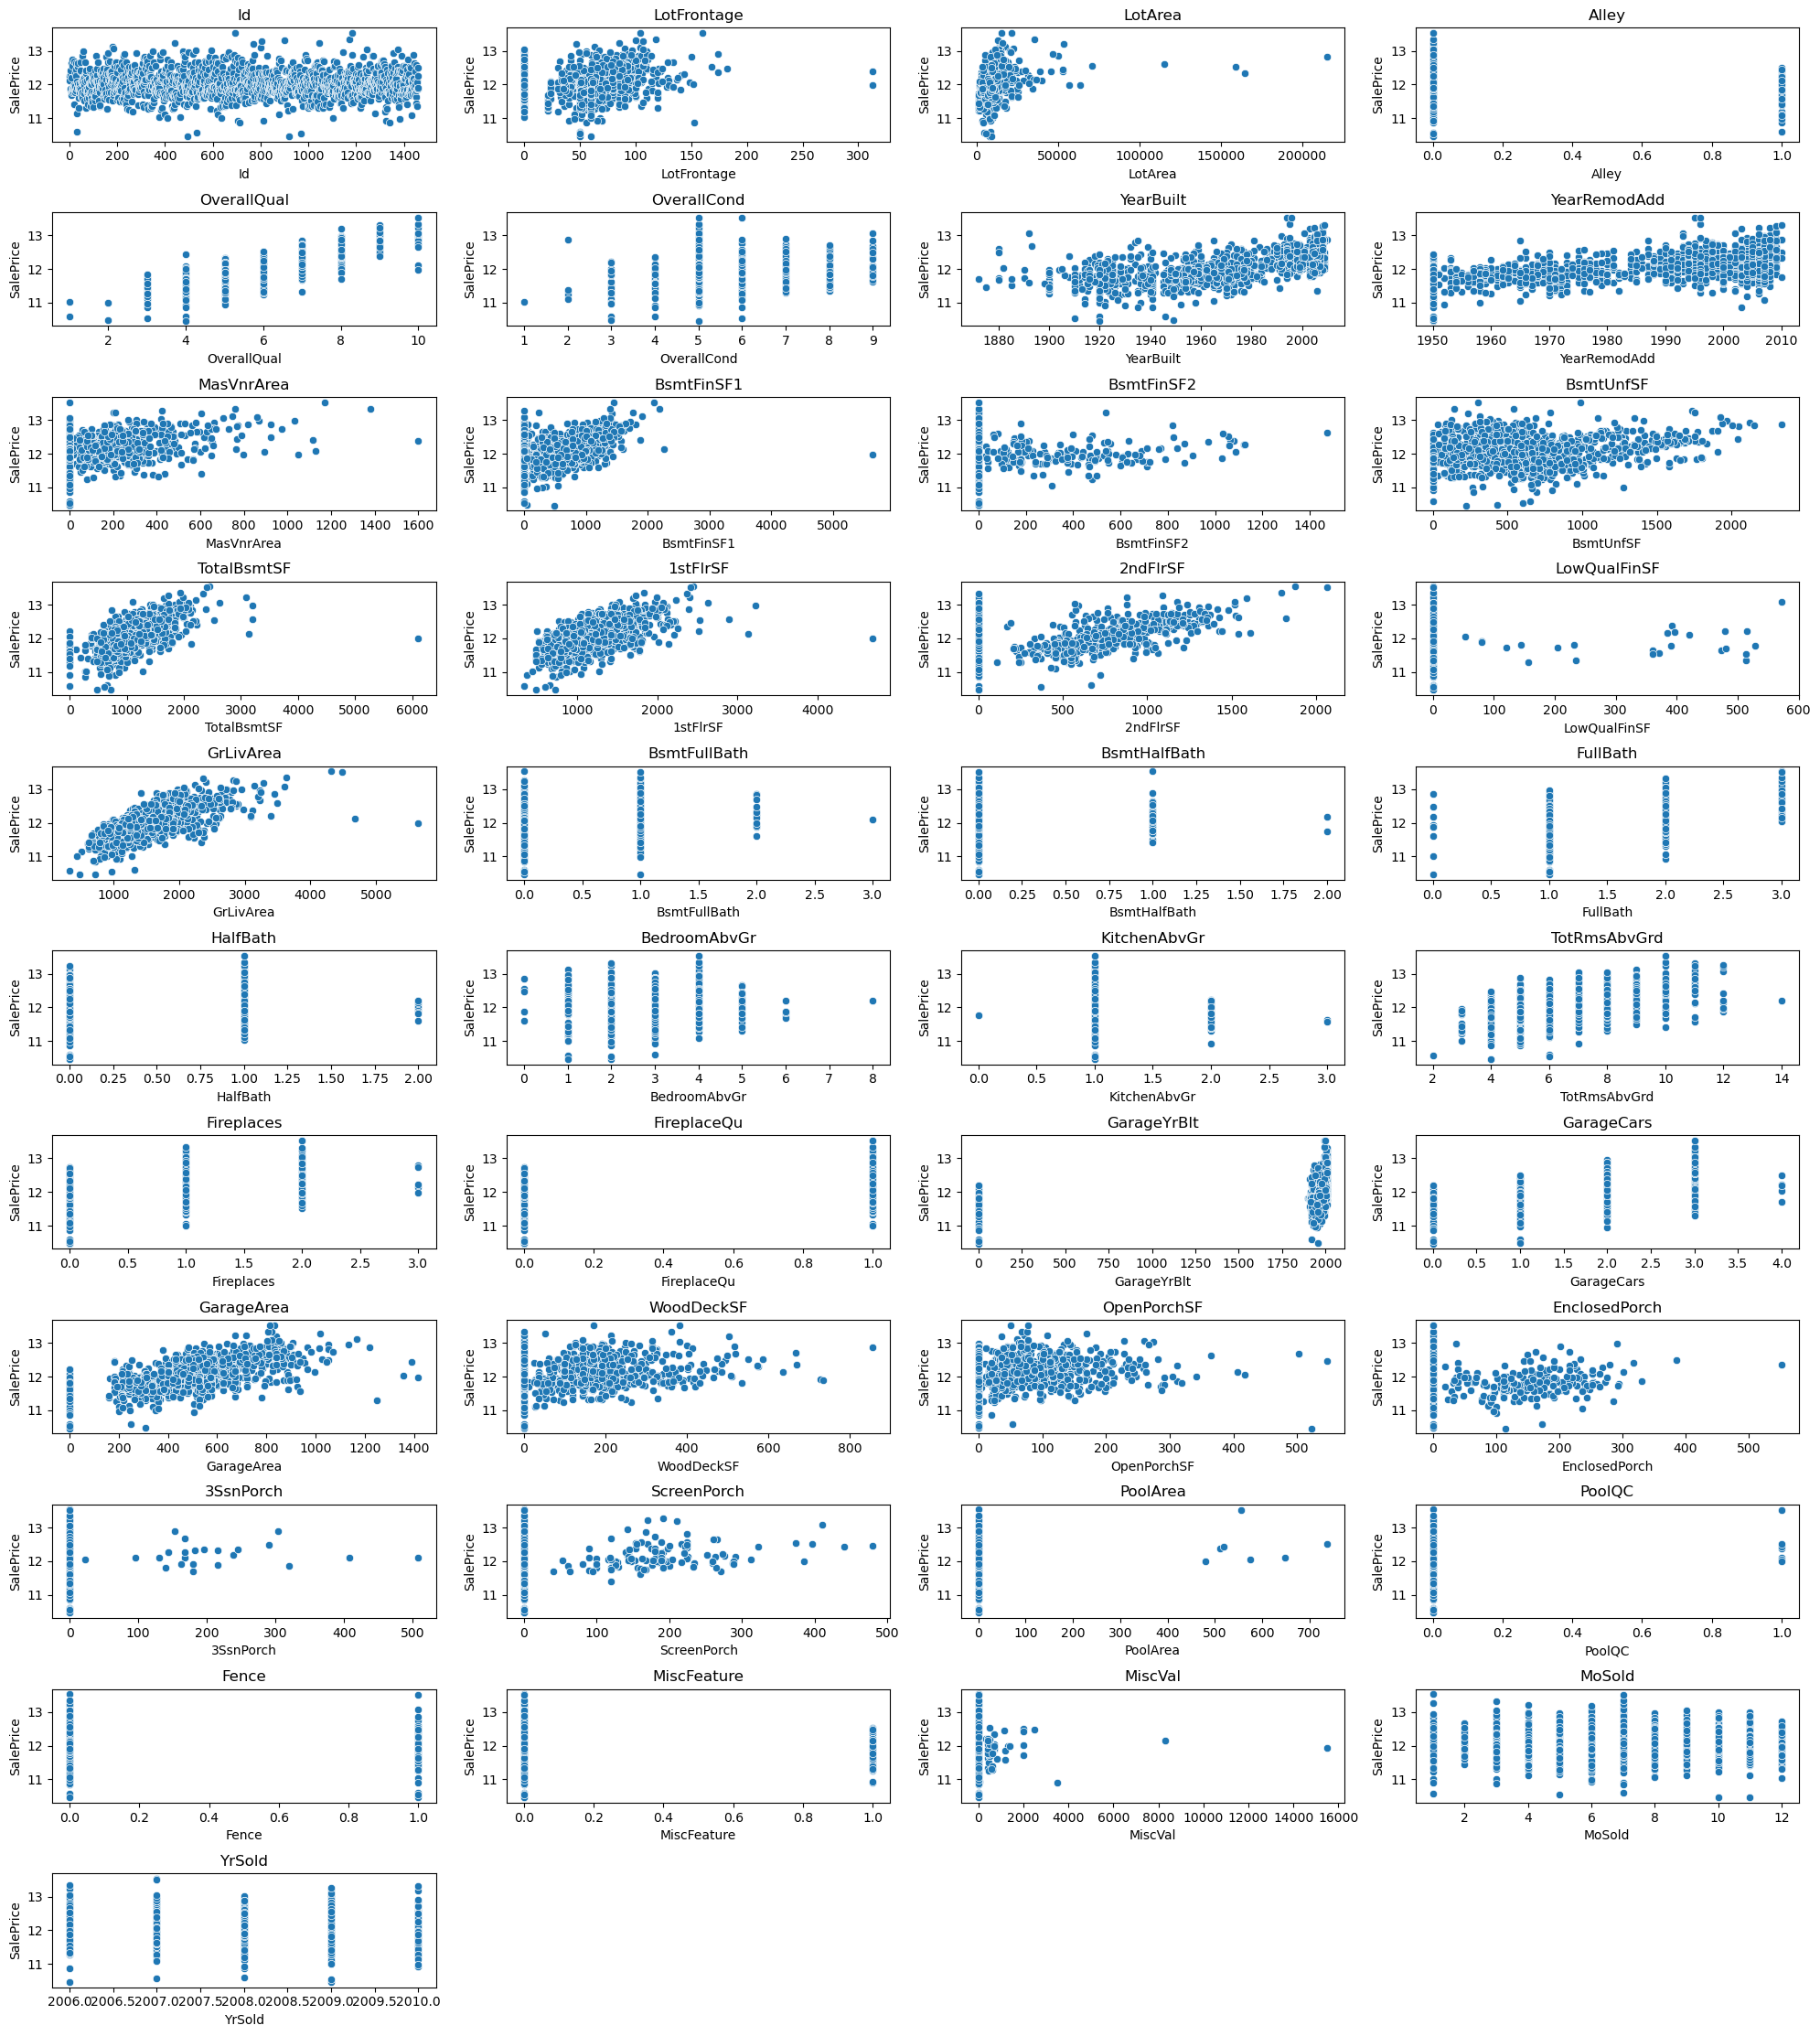

In [15]:

fig = plt.figure()
fig.set_size_inches(20,30)

for i, col in enumerate(numeric_cols):
    fig.add_subplot(15,4,i+1)
    plt.title(col)
    fig.tight_layout(h_pad=1)
    sns.scatterplot(x=df_for_vis[col],y=np.log(train_df['SalePrice']))

# Добавляем новые фичи

In [16]:
#общая площадь
concat_df['All_sqr_footage'] = (concat_df['BsmtFinSF1'] + concat_df['BsmtFinSF2'] +
                                 concat_df['1stFlrSF'] + concat_df['2ndFlrSF'])
# площадь дома общая 
concat_df['All_SF']=concat_df['TotalBsmtSF'] + concat_df['1stFlrSF'] + concat_df['2ndFlrSF']

# общее количчество ванных комнат 
concat_df['All_Bathrooms'] = (concat_df['FullBath'] + (0.5 * concat_df['HalfBath']) +
                               concat_df['BsmtFullBath'] + (0.5 * concat_df['BsmtHalfBath']))

# общая площадь веранд 
concat_df['All_porch'] = (concat_df['OpenPorchSF'] + concat_df['3SsnPorch'] +
                              concat_df['EnclosedPorch'] + concat_df['ScreenPorch'] +
                              concat_df['WoodDeckSF'])

concat_df['has_bsmt'] = concat_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

concat_df['has_pool'] = concat_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

concat_df['has_fire_place'] = concat_df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

concat_df['has_2_floor'] = concat_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

concat_df['has_garage'] = concat_df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

concat_df['Year_Blt+Remod'] = concat_df['YearRemodAdd'] + concat_df['YearBuilt']

##  Оценим корреляцию признаков с помощью корреляции спирмана

<AxesSubplot:>

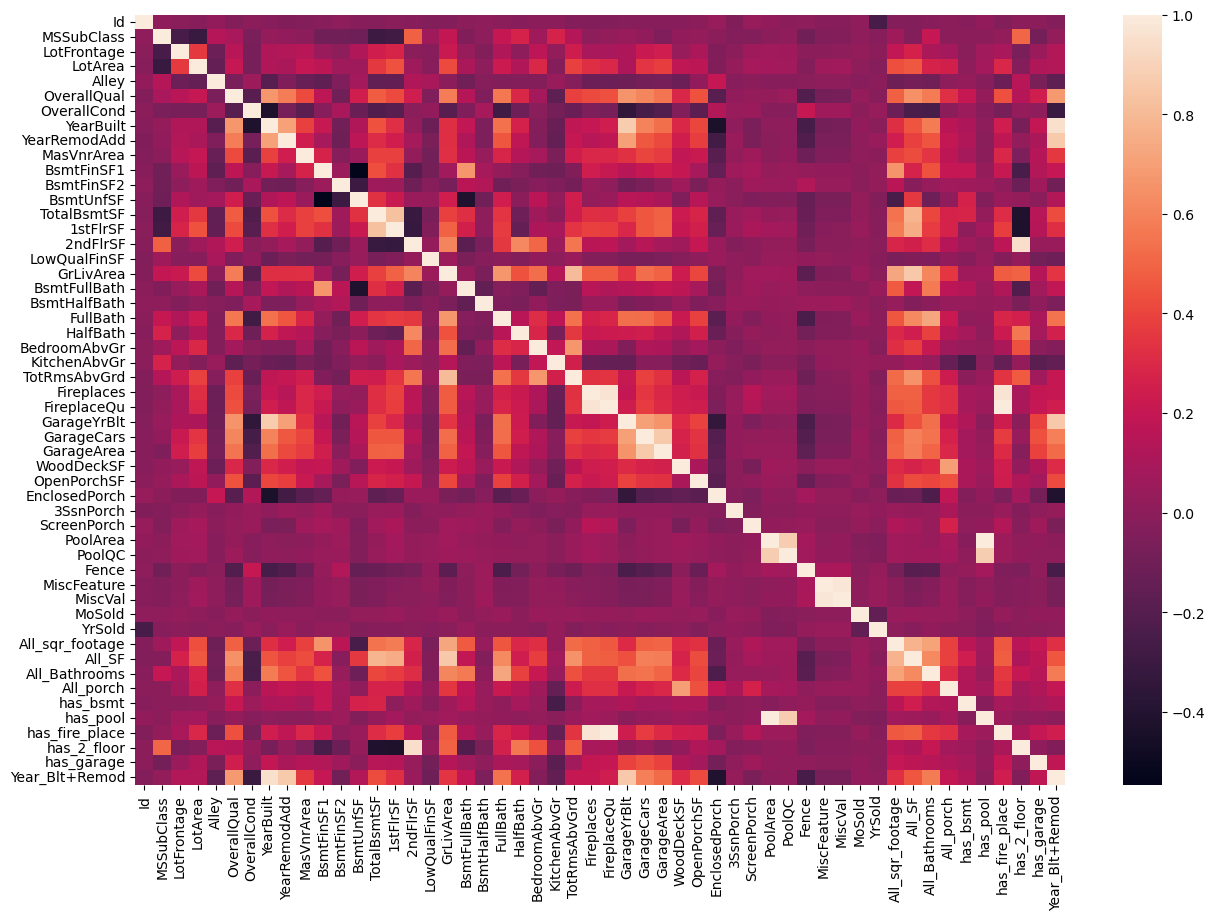

In [17]:
plt.figure(figsize=(15,10))
sns.heatmap(concat_df.corr('spearman'))


In [18]:
def correl(df, thresh):
    cor = df.corr('spearman')
    c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
    all_cor = c1[c1.values != 1]
    return all_cor[abs(all_cor) > thresh]

top_correlations = correl(concat_df, 0.7)
top_correlations

has_pool        PoolArea           0.999997
MiscVal         MiscFeature        0.979550
has_fire_place  Fireplaces         0.966392
YearBuilt       Year_Blt+Remod     0.956752
2ndFlrSF        has_2_floor        0.950383
PoolArea        PoolQC             0.876904
PoolQC          has_pool           0.876606
GarageYrBlt     YearBuilt          0.868203
Year_Blt+Remod  YearRemodAdd       0.866859
GarageCars      GarageArea         0.864929
All_SF          GrLivArea          0.858501
GarageYrBlt     Year_Blt+Remod     0.857096
1stFlrSF        TotalBsmtSF        0.828737
TotRmsAbvGrd    GrLivArea          0.808775
TotalBsmtSF     All_SF             0.777233
All_SF          All_sqr_footage    0.775524
                1stFlrSF           0.752220
GrLivArea       All_sqr_footage    0.724594
FullBath        All_Bathrooms      0.722282
All_Bathrooms   All_sqr_footage    0.714502
YearRemodAdd    YearBuilt          0.707957
GarageCars      GarageYrBlt        0.700132
dtype: float64

### в данных присутствует корреляция признаков, удалим коррелирующие колонки

In [19]:
corr_cols = [[col1,col2] for col1, col2 in top_correlations.index]

col_to_drop = []
for col_1, col_2 in corr_cols:
    corr_with_target = np.array([pd.concat((concat_df[col_1][:1460], train_df['SalePrice']), axis=1).corr().iloc[0,1],
                                 pd.concat((concat_df[col_2][:1460], train_df['SalePrice']), axis=1).corr().iloc[0,1]])
    
    col_to_drop.append([col_1,col_2][np.argmin(corr_with_target)])# удаляем ту колонку которая меньше коррелирует с таргетом

col_to_drop = list(set(col_to_drop))
concat_df.drop(col_to_drop, axis=1, inplace=True)

categ_cols = [col for col in concat_df.columns if concat_df[col].dtype == 'O']
numeric_cols = [col for col in concat_df.columns if concat_df[col].dtype != 'O']

## можно разделить численные колонки на несколько видов

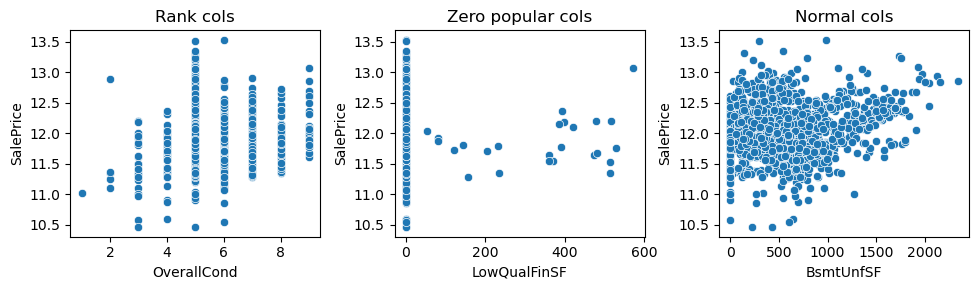

In [20]:
rank_cols = [col for col in numeric_cols if concat_df[col].nunique() < 30]

is_popularular_zero = lambda col: concat_df[col].value_counts().tolist()[0] > (concat_df[col].shape[0]/2) # больше половины значений нули 

zero_popular_cols = [col for col in numeric_cols if is_popularular_zero(col) and (col not in rank_cols) and (col not in miss_to_binary_cols)]

other_num_cols = [col for col in numeric_cols if (col not in zero_popular_cols) and (col not in rank_cols)][1:]

fig = plt.figure()
fig.set_size_inches(10,3)
col_name_list = ['Rank cols', 'Zero popular cols', 'Normal cols']
for i, cols in enumerate([rank_cols, zero_popular_cols, other_num_cols]):
    col = cols[3]
    fig.add_subplot(1,3,i+1)
    fig.tight_layout(w_pad=1)
    plt.title(f'{col_name_list[i]}')
    sns.scatterplot(x=df_for_vis[col],y=np.log(train_df['SalePrice']))
    

### почистим колонки от выбросов
### заменим их на максимальное значение 

In [21]:
threshold_dict = {'LotFrontage':140,
                  'lot_area':20000,
                  'BsmtFinSF1':1900,
                  'TotalBsmtSF':2100,
                  '1stFlrSF':2100,
                  'GrLivArea':2800,
                  'OpenPorchSF':200}

for col in other_num_cols:
    if col in list(threshold_dict.keys()):
        threshold = threshold_dict[col]
        concat_df[col][concat_df[col] > threshold] = concat_df[col][concat_df[col] < threshold].max()

        



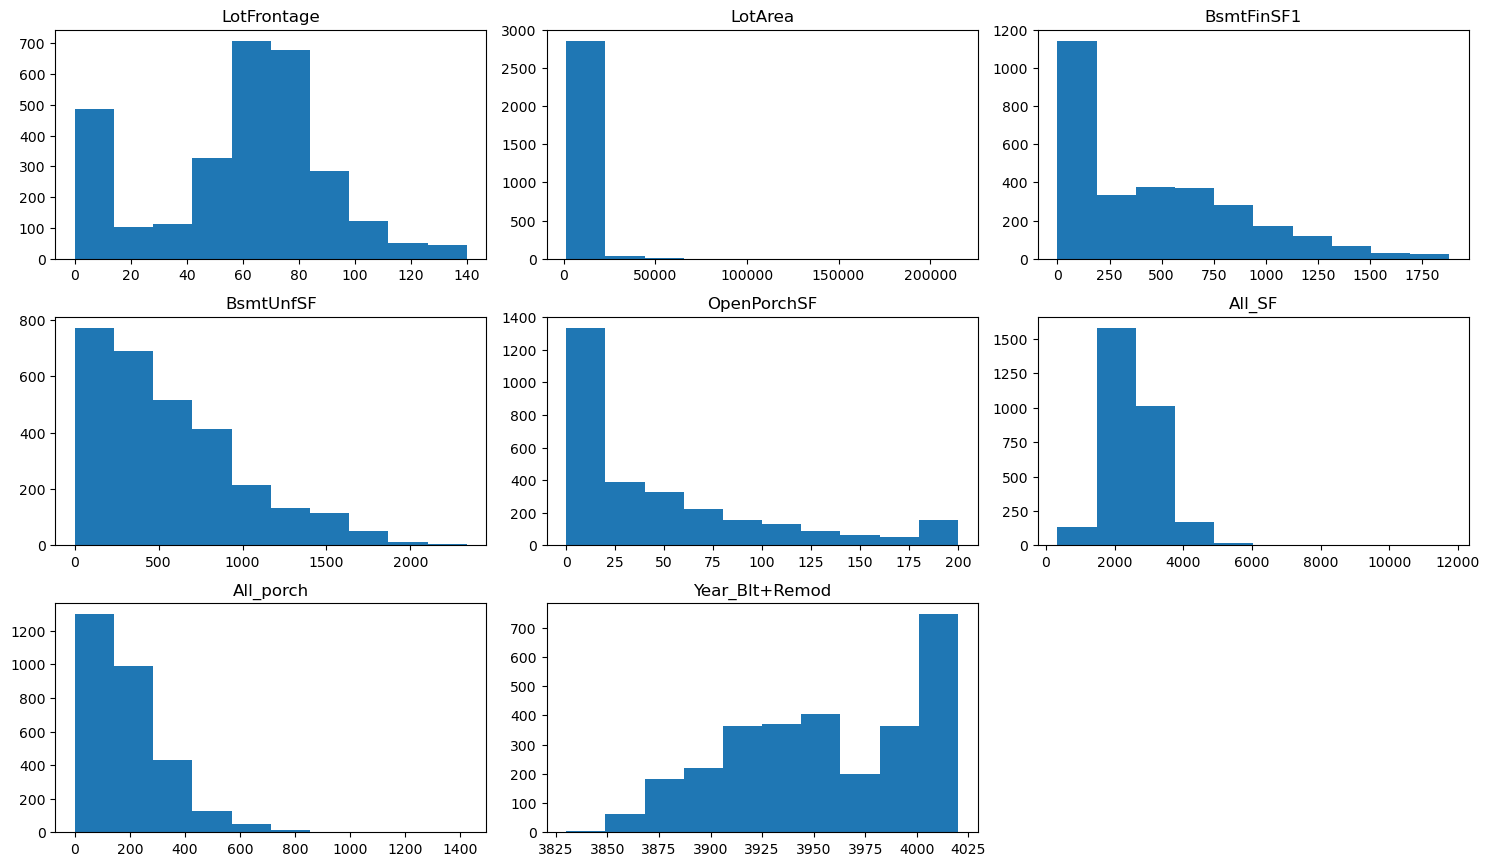

In [22]:
fig = plt.figure()
fig.set_size_inches(15,20)

for i, col in enumerate(other_num_cols):
    fig.add_subplot(7,3,i+1)
    plt.title(col)
    fig.tight_layout(h_pad=1)
    plt.hist(concat_df[col])

## вынесем zero popular колонки отдельно 

In [23]:
zero_popular_df = concat_df[zero_popular_cols].copy()

concat_df.drop(zero_popular_cols, axis=1, inplace=True)
zero_popular_df.head()

,MasVnrArea,BsmtFinSF2,2ndFlrSF,LowQualFinSF,WoodDeckSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal
0,196.0,0.0,854,0,0,0,0,0,0
1,0.0,0.0,0,0,298,0,0,0,0
2,162.0,0.0,866,0,0,0,0,0,0
3,0.0,0.0,756,0,0,272,0,0,0
4,350.0,0.0,1053,0,192,0,0,0,0


In [24]:
binary_zero_popular_df = pd.DataFrame()

for col in zero_popular_cols:
    binary_zero_popular_df[f'is_{col}'] = zero_popular_df[col].apply(lambda x: int(x > 0))
    
binary_zero_popular_df.head()

,is_MasVnrArea,is_BsmtFinSF2,is_2ndFlrSF,is_LowQualFinSF,is_WoodDeckSF,is_EnclosedPorch,is_3SsnPorch,is_ScreenPorch,is_MiscVal
0,1,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0
2,1,0,1,0,0,0,0,0,0
3,0,0,1,0,0,1,0,0,0
4,1,0,1,0,1,0,0,0,0


### неприятное свойство meantarget кодирования состоит в склонении к переобучению модели, так как признаки сильно коррелируют с таргетом
### основная цель моего енкодера - это уменьшить переобучение модели

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold


class meantarget_crossval_encoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols=None):
        self.dict_means = {}
        self.cols = cols
        
    def fit(self, X, y):
        if type(X) != pd.core.frame.DataFrame:
            X = pd.DataFrame(X)
            y = pd.Series(y)
        xy_concat = pd.concat((X,y),axis=1)
        X_c = X.copy()
        y_c = y.copy()
        
        if not self.cols:
            self.cols = X.columns
        
        # если указаны не названия колонок, а их индексы
        if type(self.cols[0]) != str:
            self.cols = X.columns[self.cols]
            
        spliter = KFold(n_splits=5)
        
        X_indexes = [x for x,y in spliter.split(X_c, y_c)] # [[1 множество индексов], [2 множество индексов] ...]
        y_indexes = [y for x,y in spliter.split(X_c, y_c)] # [[1 множество индексов], [2 множество индексов] ...]
        
        for col in self.cols:
            
            df = pd.DataFrame()
            
            # пробегаемся по всем множествам индексов
            for i in range(5):
                if i == 4:
                    y_ids = y_indexes[0]
                else:
                    y_ids = y_indexes[i+1]
                    
                X_ids = X_indexes[i]
                
                col_index = xy_concat.columns.tolist().index(col)
                
                # берем обьекты из 1 множества индексов и мерджим к ним таргеты из 2 множества множества индексов 
                merge_df = xy_concat.iloc[X_ids,[col_index]].merge(xy_concat.iloc[y_ids, [col_index, -1]], on=col)
                
                df = pd.concat((df, merge_df))
                
            means_of_col = df.groupby(col)['SalePrice'].mean()
            self.dict_means[col] = means_of_col
        return self
    
    def transform(self, df):
        temp = df.copy()
        
        for col in self.cols:
            temp[col] = temp[col].map(self.dict_means[col])
            temp[col] = temp[col].fillna(0)
            
        return temp

    
        

In [26]:
cols_for_OneHot = [concat_df.columns.tolist().index(col) for col in categ_cols if concat_df[col].nunique() <= 7]
cols_for_MeanTarg = [concat_df.columns.tolist().index(col) for col in categ_cols if concat_df[col].nunique() > 7]
cols_for_normalize = [concat_df.columns.tolist().index(col) for col in other_num_cols ]

transformers = [('scaler', StandardScaler(), cols_for_normalize),
                ('OneHot', OneHotEncoder(), cols_for_OneHot),
                ('MeanTarg', meantarget_crossval_encoder(), cols_for_MeanTarg)]

col_transformer = ColumnTransformer(transformers=transformers)

In [27]:
def get_score(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True)
    try:
        col_transformer.fit(X_train,y_train)
    except:
        print(X_train,'------\n',y_train)
    X_train = col_transformer.transform(X_train)
    X_test = col_transformer.transform(X_test)
    
    forest = RandomForestRegressor(max_depth=8, n_estimators=250).fit(X_train, y_train)
    lasso = Lasso(alpha=0.3).fit(X_train, y_train)
    xgb = XGBRegressor().fit(X_train, y_train)
    
    forest_score = (cross_validate(forest, X_test, y_test, scoring='neg_mean_squared_error')['test_score'] * -1).mean().round(4)
    lasso_score = (cross_validate(lasso, X_test, y_test, scoring='neg_mean_squared_error')['test_score'] * -1).mean().round(4)
    xgb_score = (cross_validate(xgb, X_test, y_test, scoring='neg_mean_squared_error')['test_score'] * -1).mean().round(4)
    
    return forest_score, lasso_score, xgb_score 

In [28]:
X_no_zero_popular = concat_df
X_wt_zero_popular = pd.concat((concat_df, zero_popular_df),axis=1)# с zero_popular колонками 
X_wt_bin_zero_popular = pd.concat((concat_df, binary_zero_popular_df),axis=1) # c бинарными zero_popular колонками 


y = np.log(train_df['SalePrice'])

print(f'No Zero popular- {get_score(X_no_zero_popular[:1460],y)}')
print(f'Zero popular- {get_score(X_wt_zero_popular[:1460],y)}')
print(f'Binary Zero popular- {get_score(X_wt_bin_zero_popular[:1460],y)}')

No Zero popular- (0.0266, 0.1547, 0.0348)
Zero popular- (0.0297, 0.1578, 0.0381)
Binary Zero popular- (0.0216, 0.1497, 0.0216)


In [59]:
X = col_transformer.fit_transform(X_wt_bin_zero_popular[:1460],y)
y = train_df['SalePrice']


#X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)


xgb_reg = XGBRegressor(colsample_bytree=0.4, 
                       gamma=0.04, 
                       learning_rate=0.05, 
                       max_depth=3, 
                       min_child_weight=1.7,
                       n_estimators=2200,
                       reg_alpha=0.4, 
                       reg_lambda=0.8,
                       subsample=0.5, 
                       silent=1,
                       random_state =7, 
                       nthread = -1)

lgb_reg = LGBMRegressor(objective='regression',
                        num_leaves=5,
                        learning_rate=0.05, 
                        n_estimators=720,
                        max_bin = 55, 
                        bagging_fraction = 0.8,
                        bagging_freq = 5, 
                        feature_fraction = 0.2,
                        feature_fraction_seed=9, 
                        bagging_seed=9,
                        min_data_in_leaf =6,
                        min_sum_hessian_in_leaf = 11)

forest = RandomForestRegressor(n_estimators=400,max_depth=8)

def gaus_kernel(distances, h=10):

            const = 1 / (np.sqrt(2 * np.pi))
            power = (-1/2) * ((distances)**2) / h**2

            return const * np.exp(power)

knn = KNeighborsRegressor(n_neighbors=10,
                          p=3,
                          weights=gaus_kernel)


In [60]:
class StackModel:
    
    def __init__(self, base_models, meta_model, col_transformer):
        self.base_models = base_models
        self.meta_model = meta_model
        self.col_transformer = col_transformer
        
    def fit(self, X, y):
        X_transform = self.col_transformer.fit_transform(X,y)
        
        self.base_models = [model.fit(X_transform,y) for model in self.base_models]
        
        return self.predict(X)
#         self.meta_model.fit(X_train_meta, y_train_meta)
            
    def predict(self, X):
        
        X = self.col_transformer.transform(X)
        stack_df = pd.DataFrame()
        
        for i, model in enumerate(self.base_models):
            stack_df[f'{i}'] = model.predict(X)
            
        return stack_df
        
        
    


In [83]:
X = X_no_zero_popular[:1460]
y = train_df['SalePrice']

X_train, X_test, y_train,y_test = train_test_split(X, y, shuffle=True)

stack_ensemble = StackModel(base_models=[xgb_reg, lgb_reg,forest, knn, LinearRegression(), Lasso(), Ridge()],
                            meta_model=Lasso(),
                            col_transformer=col_transformer)

In [84]:
X_train_stack = stack_ensemble.fit(X_train, np.log1p(y_train))
X_test_stack = stack_ensemble.predict(X_test)

[19:25:23] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [85]:

meta_model = XGBRegressor(colsample_bytree=0.4, 
                       gamma=0.04, 
                       learning_rate=0.05, 
                       max_depth=3, 
                       min_child_weight=1.7,
                       n_estimators=2200,
                       reg_alpha=0.4, 
                       reg_lambda=0.8,
                       subsample=0.5, 
                       silent=1,
                       random_state =7, 
                       nthread = -1)

meta_model.fit(X_train_stack, np.log1p(y_train))

[19:25:48] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.04, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1.7,
             missing=nan, monotone_constraints='()', n_estimators=2200,
             n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
             random_state=7, reg_alpha=0.4, ...)

In [92]:
pred = np.exp(meta_model.predict(X_test_stack))

np.sqrt(mse(y_test, pred))

29399.717415307397

In [104]:
X_test = X_no_zero_popular[1460:]

stack_test = stack_ensemble.predict(X_test)
np.exp(meta_model.predict(stack_test))

array([115443.125, 178948.34 , 191562.9  , ..., 146196.1  , 116786.11 ,
       194315.5  ], dtype=float32)

In [107]:
outputs = pd.DataFrame()
outputs['Id'] = test_ids
outputs['SalePrice'] = np.exp(meta_model.predict(stack_test))
outputs.to_csv('stack_preds.csv',index=False)